# Reconstruct eta->e+e-g events via machine learning based PID

Analyze eta->e+e-g data, including a dominating eta->pi+pi-g background. The networks used here are located in the folder "Trained_Classifier". Execute each cell one after the other. Many functions, like setting up the neural networks or calucalting the confusion matrix are defined in: "analysis_utils.py".

## Load libraries and settings

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load
import tensorflow as tf

#MAKE CHANGES HERE
#These are the individual thresholds, determined by the threshold scan
#within the ROC curve. Change these values and see how the performance changes...
#*******************************************************************
scikit_plus_thresh = 0.48
scikit_minus_thresh = 0.47
keras_plus_thresh = 0.42
keras_minus_thresh = 0.43

ana_add_name = 'demo' #--> Change this to customize the name of the produced plots and trained networks
#(However, it should be consistent with the name you used in 'inspect_single_tracks.py')
#*******************************************************************

## Load the eta->pi+pi-g and eta->e+e-g data

In [11]:
dataDir = 'http://hadron.physics.fsu.edu/~dlersch/Intro_To_ML_2021/data/'
dataName = 'eta_epemg_data.csv'

data_df = pd.read_csv(dataDir + dataName)
ep_features = ['ep_p','ep_theta','ep_dedx_cdc','ep_ebcal','ep_dedx_fdc','ep_efcal']
em_features = ['em_p','em_theta','em_dedx_cdc','em_ebcal','em_dedx_fdc','em_efcal']

## Load previously classifiers

In [12]:
classifierDir = 'Trained_Classifier/' #--> If you wish to use your own trained models, just change this to the folder name where you store your models
#e.g. use: classifierDir = '' if your models are stored in the same direcrtory as this script

scikit_plus = load(classifierDir + 'scikit_mlp_pos_particles_' + ana_add_name + '.joblib')
scikit_minus = load(classifierDir + 'scikit_mlp_neg_particles_' + ana_add_name + '.joblib')

keras_plus = tf.keras.models.load_model(classifierDir + 'keras_mlp_pos_particles_' + ana_add_name + '.h5')
keras_minus = tf.keras.models.load_model(classifierDir + 'keras_mlp_neg_particles_' + ana_add_name + '.h5')

## Get classifier predictions

Add them to the DataFrame and define event selection condition

In [13]:
data_df['scikit_plus_prob'] = scikit_plus.predict_proba(data_df[ep_features])[:,1]
data_df['scikit_minus_prob'] = scikit_minus.predict_proba(data_df[em_features])[:,1]
data_df['keras_plus_prob'] = keras_plus.predict(data_df[ep_features])
data_df['keras_minus_prob'] = keras_minus.predict(data_df[em_features])

scikit_accepted = (data_df['scikit_plus_prob'] >= scikit_plus_thresh) & (data_df['scikit_minus_prob'] >= scikit_minus_thresh)
keras_accepted = (data_df['keras_plus_prob'] >= keras_plus_thresh) & (data_df['keras_minus_prob'] >= keras_minus_thresh)

## Get (e+ e- g) invariant mass prior to PID

This is the distribution shown at the beginning of the lecture.

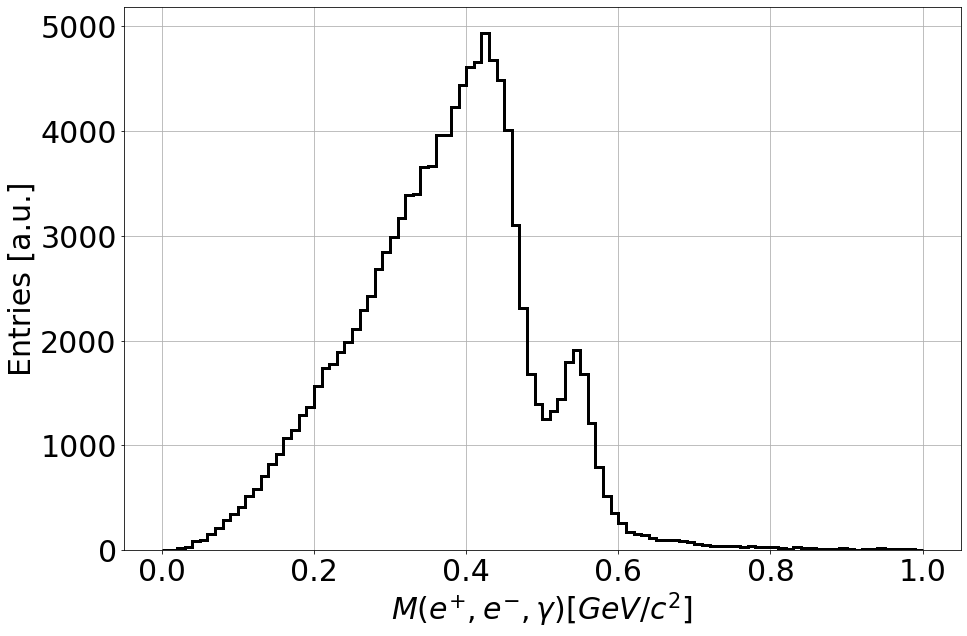

In [14]:
plt.rcParams.update({'font.size': 30})
fig,ax = plt.subplots(figsize=(15,10))
ax.hist(data_df['im_eeg'],bins=100,range=(0.0,1.0),histtype='step',fill=False,linewidth=3.0,color='k')
ax.grid(True)
ax.set_xlabel(r'$M(e^{+},e^{-},\gamma)[GeV/c^{2}]$')
ax.set_ylabel('Entries [a.u.]')

fig.savefig('eta_epemg_noPID_' + ana_add_name + '.png')

## Get (e+ e- g) invariant mass after PID

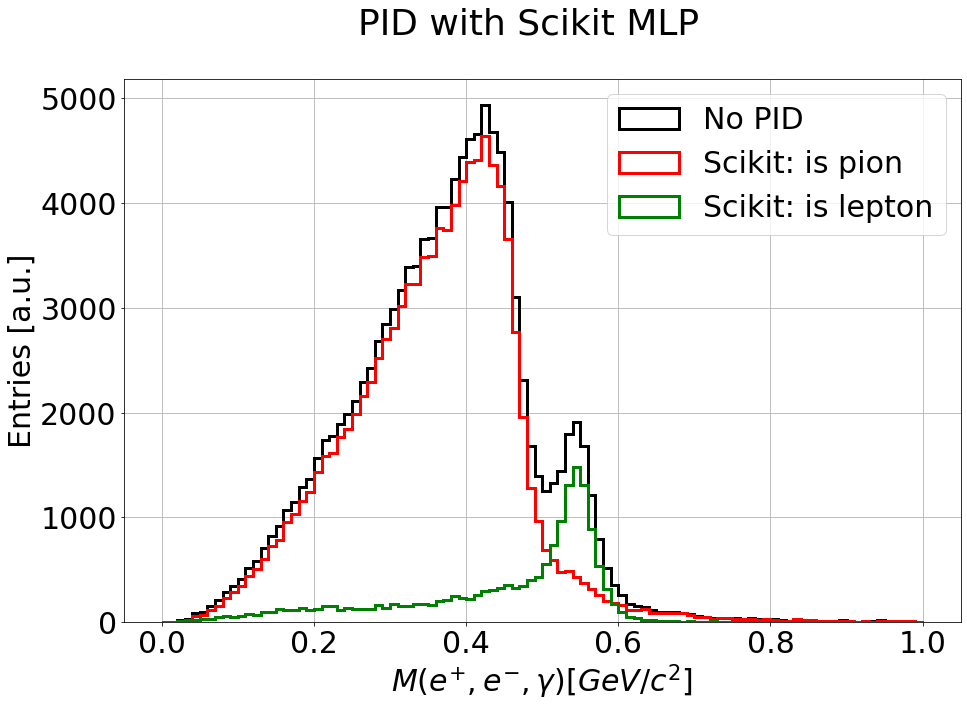

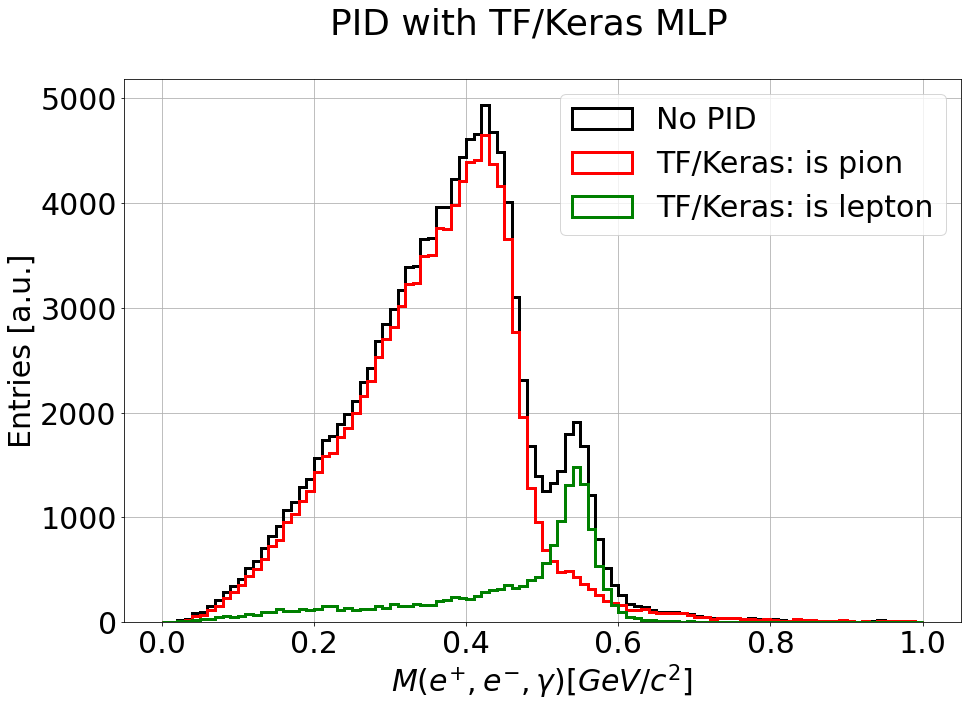

In [17]:
fig_scikit,ax_scikit = plt.subplots(figsize=(15,10))

fig_scikit.suptitle('PID with Scikit MLP')
ax_scikit.hist(data_df['im_eeg'],bins=100,range=(0.0,1.0),histtype='step',fill=False,linewidth=3.0,color='k',label='No PID')
ax_scikit.hist(data_df[~scikit_accepted]['im_eeg'],bins=100,range=(0.0,1.0),histtype='step',fill=False,linewidth=3.0,color='r',label='Scikit: is pion')
ax_scikit.hist(data_df[scikit_accepted]['im_eeg'],bins=100,range=(0.0,1.0),histtype='step',fill=False,linewidth=3.0,color='g',label='Scikit: is lepton')
ax_scikit.legend()
ax_scikit.grid(True)
ax_scikit.set_xlabel(r'$M(e^{+},e^{-},\gamma)[GeV/c^{2}]$')
ax_scikit.set_ylabel('Entries [a.u.]')

fig_scikit.savefig('eta_epemg_scikitPID_' + ana_add_name + '.png')

fig_keras,ax_keras = plt.subplots(figsize=(15,10))
fig_keras.suptitle('PID with TF/Keras MLP')
ax_keras.hist(data_df['im_eeg'],bins=100,range=(0.0,1.0),histtype='step',fill=False,linewidth=3.0,color='k',label='No PID')
ax_keras.hist(data_df[~keras_accepted]['im_eeg'],bins=100,range=(0.0,1.0),histtype='step',fill=False,linewidth=3.0,color='r',label='TF/Keras: is pion')
ax_keras.hist(data_df[keras_accepted]['im_eeg'],bins=100,range=(0.0,1.0),histtype='step',fill=False,linewidth=3.0,color='g',label='TF/Keras: is lepton')
ax_keras.legend()
ax_keras.grid(True)
ax_keras.set_xlabel(r'$M(e^{+},e^{-},\gamma)[GeV/c^{2}]$')
ax_keras.set_ylabel('Entries [a.u.]')

fig_keras.savefig('eta_epemg_kerasPID_' + ana_add_name + '.png')

## Compare (e+ e- g) invariant masses between scikit and keras based PID

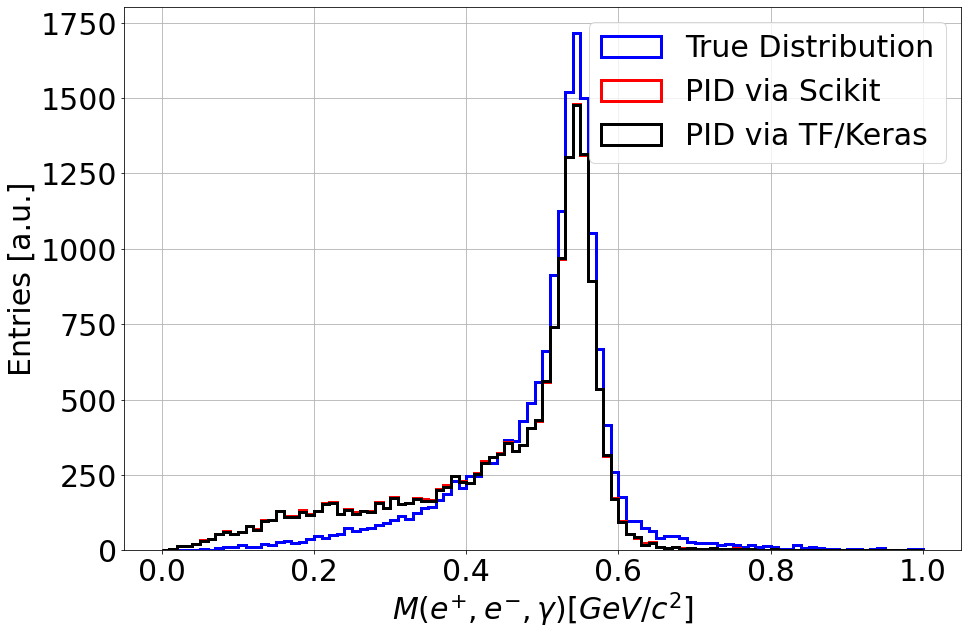

In [16]:
fig_comp,ax_comp = plt.subplots(figsize=(15,10))
ax_comp.hist(data_df[data_df['label']==1.0]['im_eeg'],bins=100,range=(0.0,1.0),histtype='step',fill=False,linewidth=3.0,color='b',label='True Distribution')
ax_comp.hist(data_df[scikit_accepted]['im_eeg'],bins=100,range=(0.0,1.0),histtype='step',fill=False,linewidth=3.0,color='r',label='PID via Scikit')
ax_comp.hist(data_df[keras_accepted]['im_eeg'],bins=100,range=(0.0,1.0),histtype='step',fill=False,linewidth=3.0,color='k',label='PID via TF/Keras')
ax_comp.legend()
ax_comp.grid(True)
ax_comp.set_xlabel(r'$M(e^{+},e^{-},\gamma)[GeV/c^{2}]$')
ax_comp.set_ylabel('Entries [a.u.]')

fig_comp.savefig('compare_eta_epemg_PID_' + ana_add_name + '.png')